In [1]:
!pip install optax


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 180.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 MB 232.9 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 219.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 235.7 MB/s  0:00:00
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.14.1
    Uninstalling typing_extensions-4.14.1:
      Successfully uninstalled typing_extensions-4.14.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10/10 [optax]m 9/10 [optax]]]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
!pip install pennylane pandas matplotlib


In [ ]:
!pip install jax jaxlib optax

# Global Appliance Optimization

## Phase 1: Setup, Data Loading, and Parameter Definition. 
This code will import our libraries, load the smart_grid_dataset_2024.csv file, and set up all the "Given" parameters from our Energy_qubo.pdf document.

In [2]:
# Step 1: Setup, Data Loading, and Parameter Definition
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def warn (*args, **kwargs):
    pass
import warnings
warnings.filterwarnings('ignore')

print("Phase 1: Setup & Data Preparation")

#  1. Load Data 
try:
    df = pd.read_csv("smart_grid_dataset_2024.csv")
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
except FileNotFoundError:
    print("ERROR: 'smart_grid_dataset_2024.csv' not found.")
    # In a real notebook, we'd stop execution here

#  2. Create Time-Series Arrays (The "Givens") 
# Filter for our 24-hour period (Jan 1, 2024)
df_24h = df[df['Timestamp'].dt.date == pd.to_datetime('2024-01-01').date()].copy()

if len(df_24h) != 96:
    print(f"Warning: Expected 96 time steps, but found {len(df_24h)}.")

# Total time steps (T = 96)
T = len(df_24h) 

# B_t: Baseline Load (kW)
B_t = df_24h['Power Consumption (kW)'].values

# C_t: Energy Price (USD/kWh)
C_t = df_24h['Electricity Price (USD/kWh)'].values

# R_t: Renewable Production (kW)
R_t = (df_24h['Solar Power (kW)'] + df_24h['Wind Power (kW)']).values

print(f"Data loaded for {T} time steps.")

# 3. Define Appliance Parameters (The "Problem Space") 
# As defined in Energy_qubo.pdf
# Note: We convert time windows to integer indices (0-95)
# 8:00 AM = 8*4 = 32
# 8:00 PM = 20*4 = 80
# 10:00 PM = 22*4 = 88
'''appliances = {
    'ev_charger': {
        'P': 9.0,  # kW
        'L': 16,   # 16 steps = 4 hours
        # Window: 10:00 PM (88) to 6:00 AM (ends at step 23)
        'window': list(range(88, 96)) + list(range(0, 24 - 16 + 1)) 
    },
    'washing_machine': {
        'P': 1.5,  # kW
        'L': 4,    # 4 steps = 1 hour
        # Window: 8:00 AM (32) to 10:00 PM (ends at step 87)
        'window': list(range(32, 88 - 4 + 1))
    },
    'dishwasher': {
        'P': 1.8,  # kW
        'L': 6,    # 6 steps = 1.5 hours
        # Window: 8:00 PM (80) to 5:00 AM (ends at step 19)
        'window': list(range(80, 96)) + list(range(0, 20 - 6 + 1))
    }
}'''

# Note on windows: The window list contains all valid START times.
# e.g., washing machine must END by step 87, so it must START by 87 - 4 = 83.
# We've adjusted the range() function accordingly.



# --- 3. Define Appliance Parameters (PRUNED) ---
# We are adding a 'step=4' to the window ranges to reduce the
# number of qubits. This restricts starts to hourly intervals.

print("Redefining Appliance Parameters (Pruned for Simulation)")

appliances = {
    'ev_charger': {
        'P': 9.0,  # kW
        'L': 16,   # 16 steps = 4 hours
        # Window: 10:00 PM (88) to 6:00 AM (ends at step 23)
        'window': list(range(88, 96, 4)) + list(range(0, 24 - 16 + 1, 4)) 
    },
    'washing_machine': {
        'P': 1.5,  # kW
        'L': 4,    # 4 steps = 1 hour
        # Window: 8:00 AM (32) to 10:00 PM (ends at step 87)
        'window': list(range(32, 88 - 4 + 1, 4))
    },
    'dishwasher': {
        'P': 1.8,  # kW
        'L': 6,    # 6 steps = 1.5 hours
        # Window: 8:00 PM (80) to 5:00 AM (ends at step 19)
        'window': list(range(80, 96, 4)) + list(range(0, 20 - 6 + 1, 4))
    }
}

print("Appliance parameters (pruned) are now defined.")
#print("Appliance parameters defined.")
print("Phase 1 Complete ")

ModuleNotFoundError: No module named 'pennylane'

- We will now write the code to translate our QUBO formulation from Energy_qubo.pdf into a format PennyLane understands (an Ising Hamiltonian). 
- This involves building the $h$ (single-qubit) and $J$ (two-qubit) coefficients.
- Step 2: Building the Ising HamiltonianThis code block defines our decision variables (qubits) and then meticulously builds the $h$ and $J$ coefficients for each of our three Hamiltonian terms, based on the equations in our PDF

In [2]:
print("\n Phase 2: Building the Ising Hamiltonian ")

#  4. Define Qubit Mapping (Decision Variables) 
# We need to map each possible start time for each appliance to a unique qubit.
# x_{i,t} -> qubit_index

qubit_map = {} # {('appliance_name', start_time): qubit_index}
reverse_map = {} # {qubit_index: ('appliance_name', start_time)}
current_qubit_index = 0

for app_name, details in appliances.items():
    for start_time in details['window']:
        qubit_map[(app_name, start_time)] = current_qubit_index
        reverse_map[current_qubit_index] = (app_name, start_time)
        current_qubit_index += 1

n_qubits = len(qubit_map)
print(f"Total number of decision variables (qubits): {n_qubits}")

# --- 5. Define Hyperparameters (A, B, C) ---
# These are the "lambda" knobs we discussed.
A = 1.0  # Weight for Cost
B = 1.5  # Weight for Peak Load (prioritizing this, as discussed)
C = 50.0 # Penalty for constraints (must be the largest)
print(f"Hyperparameters: A={A}, B={B}, C={C}")

# --- 6. Build Hamiltonian Coefficients (h, J) ---
# We will build the coefficients for the Ising model:
# H = sum_i(h_i * s_i) + sum_{i<j}(J_{ij} * s_i * s_j) + Offset
# We use the substitution x = (1 - s) / 2
# A linear term x_i becomes: (1 - s_i) / 2 = 0.5 - 0.5*s_i
# A quadratic term x_i*x_j becomes: (1 - s_i)(1 - s_j) / 4 = 0.25 - 0.25*s_i - 0.25*s_j + 0.25*s_i*s_j

h = {}  # h_i coefficients (single-qubit terms)
J = {}  # J_ij coefficients (two-qubit interaction terms)
offset = 0.0 # Constant offset

# 6a. H_cost_term 
# H_cost = A * sum_{i,t} (C_{i,t} * x_{i,t})
#
print("Building H_cost...")
for (app_name, start_time), qubit_idx in qubit_map.items():
    app = appliances[app_name]
    P = app['P']
    L = app['L']
    
    # Pre-calculate the cost C_{i,t} for this start time
    cost_of_run = 0.0
    for t in range(start_time, start_time + L):
        # Use modulo T to handle windows wrapping past midnight
        cost_of_run += C_t[t % T] 
    
    C_i_t = P * cost_of_run
    
    # H_cost = A * C_i_t * x_i
    # Substitute x_i = (1 - s_i) / 2
    # H_cost = A * C_i_t * (0.5 - 0.5 * s_i)
    # H_cost = (0.5 * A * C_i_t) - (0.5 * A * C_i_t * s_i)
    
    offset += A * C_i_t * 0.5
    h[qubit_idx] = h.get(qubit_idx, 0.0) - (A * C_i_t * 0.5)

# 6b. H_constraint_term 
# H_constraint = C * sum_i ( (sum_t(x_{i,t}) - 1)^2 )
# H_constraint = C * sum_i ( (sum_t(x_{i,t})^2) - 2*sum_t(x_{i,t}) + 1 )
# Since x_i^2 = x_i for binary:
# H_constraint = C * sum_i ( sum_t(x_{i,t}) + 2*sum_{t<t'}(x_{i,t}*x_{i,t'}) - 2*sum_t(x_{i,t}) + 1 )
# H_constraint = C * sum_i ( 2*sum_{t<t'}(x_{i,t}*x_{i,t'}) - sum_t(x_{i,t}) + 1 )
#
print("Building H_constraint...")
for app_name, app_details in appliances.items():
    app_qubits = [qubit_map[(app_name, t)] for t in app_details['window']]
    
    # Add constant offset term: C * sum_i(1)
    offset += C
    
    # Add linear term: -C * sum_i(sum_t(x_{i,t}))
    for qubit_idx in app_qubits:
        # Term is -C * x_i
        # Substitute x_i = (0.5 - 0.5 * s_i)
        # Term = -C * (0.5 - 0.5 * s_i) = (-0.5 * C) + (0.5 * C * s_i)
        offset -= 0.5 * C
        h[qubit_idx] = h.get(qubit_idx, 0.0) + (0.5 * C)
        
    # Add quadratic term: 2*C * sum_i(sum_{t<t'}(x_{i,t}*x_{i,t'}))
    for i in range(len(app_qubits)):
        for j in range(i + 1, len(app_qubits)):
            q_i = app_qubits[i]
            q_j = app_qubits[j]
            
            # Term is 2 * C * x_i * x_j
            # Substitute x_i*x_j = 0.25 - 0.25*s_i - 0.25*s_j + 0.25*s_i*s_j
            # Term = 2*C * (0.25 - 0.25*s_i - 0.25*s_j + 0.25*s_i*s_j)
            # Term = (0.5*C) - (0.5*C*s_i) - (0.5*C*s_j) + (0.5*C*s_i*s_j)
            
            offset += 0.5 * C
            h[q_i] = h.get(q_i, 0.0) - (0.5 * C)
            h[q_j] = h.get(q_j, 0.0) - (0.5 * C)
            
            # Ensure J key is (min_idx, max_idx)
            J_key = tuple(sorted((q_i, q_j)))
            J[J_key] = J.get(J_key, 0.0) + (0.5 * C)


# 6c. H_peak_term_v2 
# This is the most complex term.
# H_peak = B * sum_t ( (B_t + L_deferrable(t) - R_t)^2 )
# H_peak = B * sum_t ( (L_deferrable(t) + (B_t - R_t))^2 )
# H_peak = B * sum_t ( L_deferrable(t)^2 + 2*L_deferrable(t)*(B_t - R_t) + (B_t - R_t)^2 )
#
print("Building H_peak...")
for t in range(T):
    # Constant term: B * (B_t - R_t)^2
    net_baseline = B_t[t] - R_t[t]
    offset += B * (net_baseline ** 2)
    
    # We need to find all x_{i,k} that are 'ON' at time t
    # L_deferrable(t) = sum_i (P_i * sum_{k=t-L_i+1 to t} (x_{i,k}))
    #
    
    L_def_terms = [] # List of (qubit_index, power_P_i)
    for (app_name, start_time), qubit_idx in qubit_map.items():
        app = appliances[app_name]
        P = app['P']
        L = app['L']
        
        # Check if an appliance starting at 'start_time' is ON at time 't'
        # This handles wrapping around midnight
        is_on = False
        if start_time + L > T: # Wraps around
            if (t >= start_time) or (t < (start_time + L) % T):
                is_on = True
        else: # Does not wrap
            if (t >= start_time) and (t < start_time + L):
                is_on = True
        
        if is_on:
            L_def_terms.append((qubit_idx, P))

    # Linear term: B * 2 * L_deferrable(t) * (B_t - R_t)
    # Term = 2 * B * net_baseline * sum(P_i * x_i)
    for qubit_idx, P_i in L_def_terms:
        # Term = (2 * B * net_baseline * P_i) * x_i
        # Substitute x_i = (0.5 - 0.5 * s_i)
        # Term = (B * net_baseline * P_i) - (B * net_baseline * P_i * s_i)
        
        coeff = B * net_baseline * P_i
        offset += coeff
        h[qubit_idx] = h.get(qubit_idx, 0.0) - coeff

    # Quadratic term: B * (L_deferrable(t)^2)
    # Term = B * (sum(P_i * x_i))^2
    # Term = B * (sum_i( (P_i*x_i)^2 ) + 2*sum_{i<j}( P_i*P_j*x_i*x_j ))
    # Since x_i^2 = x_i (binary):
    # Term = B * (sum_i( P_i^2 * x_i ) + 2*sum_{i<j}( P_i*P_j*x_i*x_j ))
    
    # Quadratic's linear part: B * sum_i( P_i^2 * x_i )
    for qubit_idx, P_i in L_def_terms:
        # Term = B * P_i^2 * x_i
        # Substitute x_i = (0.5 - 0.5 * s_i)
        # Term = (0.5 * B * P_i^2) - (0.5 * B * P_i^2 * s_i)
        
        coeff = 0.5 * B * (P_i**2)
        offset += coeff
        h[qubit_idx] = h.get(qubit_idx, 0.0) - coeff

    # Quadratic's quadratic part: B * 2 * sum_{i<j}( P_i*P_j*x_i*x_j )
    for i in range(len(L_def_terms)):
        for j in range(i + 1, len(L_def_terms)):
            q_i, P_i = L_def_terms[i]
            q_j, P_j = L_def_terms[j]
            
            # Term = 2 * B * P_i * P_j * x_i * x_j
            # Substitute x_i*x_j = 0.25 - 0.25*s_i - 0.25*s_j + 0.25*s_i*s_j
            # Term = (0.5*B*P_i*P_j) - (0.5*B*P_i*P_j*s_i) - (0.5*B*P_i*P_j*s_j) + (0.5*B*P_i*P_j*s_i*s_j)
            
            coeff = 0.5 * B * P_i * P_j
            
            offset += coeff
            h[q_i] = h.get(q_i, 0.0) - coeff
            h[q_j] = h.get(q_j, 0.0) - coeff
            
            J_key = tuple(sorted((q_i, q_j)))
            J[J_key] = J.get(J_key, 0.0) + coeff

# 7. Create PennyLane Hamiltonian Object 
h_coeffs = list(h.values())
h_obs = [qml.PauliZ(i) for i in h.keys()]

J_coeffs = list(J.values())
J_obs = [qml.PauliZ(i) @ qml.PauliZ(j) for i, j in J.keys()]

H_Ising = qml.Hamiltonian(h_coeffs + J_coeffs, h_obs + J_obs)

print(f"Built Ising Hamiltonian with {len(h_coeffs)} single-qubit terms")
print(f"and {len(J_coeffs)} two-qubit terms.")
print(f"Constant Offset (ignored by optimizer): {offset}")
print(" Phase 2 Complete ")


 Phase 2: Building the Ising Hamiltonian 
Total number of decision variables (qubits): 27
Hyperparameters: A=1.0, B=1.5, C=50.0
Building H_cost...
Building H_constraint...
Building H_peak...
Built Ising Hamiltonian with 27 single-qubit terms
and 154 two-qubit terms.
Constant Offset (ignored by optimizer): 182455.3639871662
 Phase 2 Complete 


### Summary of What We've Done
- Qubit Mapping: We created a qubit_map that assigns a unique qubit index (e.g., 0 to n_qubits-1) to every valid start-time decision variable. We found we have 86 qubits for this problem. 
- Hyperparameters: We set our weights A, B, and C.
- Substitution: We systematically applied the $x = (1 - s) / 2$ substitution to all three parts of our Hamiltonian from Energy_qubo.pdf.
- Coefficient Building: We iterated through all appliances and time steps to build the h (single-qubit) and J (two-qubit) coefficient dictionaries. This was complex, especially for the constraint and peak-load terms, but it's the core of the problem.
- Hamiltonian Object: We combined these coefficients into a qml.Hamiltonian object. This H_Ising is the final problem object that PennyLane will solve.

## Phase 3. 
- We will define our high-performance simulator (lightning.qubit) and then create the QAOA "cost function" (the QNode) that PennyLane will learn to optimize. This QNode takes our H_Ising Hamiltonian from Step 2 as its objective.

Step 3: Define the QAOA Circuit

In [3]:
print("\n Phase 3: Define the QAOA Circuit ")

# 8. Select Device
# We use "lightning.qubit" for a high-performance C++ simulator
try:
    # Use default.qubit, as JAX will control the execution
    # --- OLD CODE ---
# dev = qml.device("default.qubit", wires=n_qubits)

# --- NEW CODE ---
    dev = qml.device("lightning.gpu", wires=n_qubits)
    print(f"Device selected: lightning.gpu with {n_qubits} wires.")
except qml.DeviceError:
    print("Warning: 'pennylane-lightning' not installed. Falling back to 'default.qubit'.")
    print("For faster performance, run: pip install pennylane-lightning")
    dev = qml.device("default.qubit", wires=n_qubits)

# 9. Define QAOA Hyperparameters 
p = 2  # Number of QAOA layers (p)
print(f"QAOA layers (p) = {p}")

# --- 10. Define the Mixer Hamiltonian ---
# This is the standard QAOA mixer, a sum of PauliX on all qubits
mixer_H = qml.Hamiltonian(
    [1.0] * n_qubits,
    [qml.PauliX(i) for i in range(n_qubits)]
)
print("Mixer Hamiltonian defined.")

# 11. Define the Cost Function (QNode) 
# This circuit manually builds the QAOA layers.
# This is the modern, robust way and replaces the old 'QAOAAnsatz'.

# --- OLD CODE ---
# @qml.qnode(dev)
# --- OLD CODE ---
# @qml.qnode(dev, interface="jax")

# --- NEW CODE ---
@qml.qnode(dev, interface="jax")
def cost_circuit(params):
    # ...
    # ... (rest of the function is the same)
    # ... (rest of the function is the same)
    # 1. Start in the |+> state (superposition)
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
    
    # 2. Apply p layers of Cost and Mixer Hamiltonians
    for i in range(p):
        gamma = params[i, 0]  # Cost parameter
        beta = params[i, 1]   # Mixer parameter
        
        # Apply cost Hamiltonian: exp(-i * gamma * H_Ising)
        # We use ApproxTimeEvolution which is a standard template
        qml.templates.ApproxTimeEvolution(H_Ising, gamma, 1)
        
        # Apply mixer Hamiltonian: exp(-i * beta * mixer_H)
        qml.templates.ApproxTimeEvolution(mixer_H, beta, 1)
    
    # 3. Measure the expected value of our cost Hamiltonian
    return qml.expval(H_Ising)

# At the top of your Phase 3 cell, add this import
import jax

# ... (rest of the cell) ...

# 12. Initialize Parameters 
# We need p layers, and each layer has 2 parameters (gamma, beta)
np.random.seed(42) # for reproducibility

# Create a standard numpy array first
numpy_params = np.random.rand(p, 2) * 0.1 

# <<< CHANGE HERE: Convert the numpy array to a JAX array >>>
params = jax.device_put(numpy_params) 

print("Cost circuit and initial parameters are defined.")
print(f"Parameter shape (p, 2): {params.shape}")
print(f"Initial params are JAX arrays: {isinstance(params, jax.Array)}")
print("Phase 3 Complete")


 Phase 3: Define the QAOA Circuit 
For faster performance, run: pip install pennylane-lightning
QAOA layers (p) = 2
Mixer Hamiltonian defined.
Cost circuit and initial parameters are defined.
Parameter shape (p, 2): (2, 2)
Initial params are JAX arrays: True
Phase 3 Complete


### Summary of What We've Done
- Device: We've instantiated the lightning.qubit simulator, which will run our QAOA circuit very quickly.

- QAOA Layers: We've set p=2, meaning our circuit will have two layers of the cost Hamiltonian and two layers of the mixer Hamiltonian.

- Cost QNode: We've created cost_circuit, a quantum function that PennyLane can differentiate and optimize. It uses the qml. QAOAAnsatz template, which saves us from having to write the circuit manually.

- Parameters: We've created an initial set of random angles (params) to give the optimizer a starting point.

In [4]:
# Save Hamiltonian coefficients and operators to a text file
filename = "ising_hamiltonian.txt"

try:
    with open(filename, "w") as f:
        f.write("Single-qubit terms (h):\n")
        for coeff, obs in zip(h_coeffs, h_obs):
            f.write(f"{coeff}: {obs}\n")
        f.write("\nTwo-qubit terms (J):\n")
        for coeff, obs in zip(J_coeffs, J_obs):
            f.write(f"{coeff}: {obs}\n")
        f.write(f"\nConstant Offset: {offset}\n")
    print(f"Successfully saved Hamiltonian to {filename}")
except Exception as e:
    print(f"Error saving Hamiltonian: {e}")

Successfully saved Hamiltonian to ising_hamiltonian.txt


## Phase 4. 
- This block will create an optimizer, set up the training loop, and run it to find the best parameters for our QAOA circuit.


 Phase 4: Run the Optimization 
Optimizer: Optax Adam (JAX), Steps: 300
Starting optimization... (This may take a few minutes)
Step    20 | Cost =    -8.056852
Step    40 | Cost =  -102.432297
Step    60 | Cost =   -24.698284
Step    80 | Cost =     0.805492
Step   100 | Cost =   -15.649645
Step   120 | Cost =   -17.914362
Step   140 | Cost =   -10.194711
Step   160 | Cost =  -162.165756
Step   180 | Cost =    -8.269573
Step   200 | Cost =    -2.257443
Step   220 | Cost =    -2.588400
Step   240 | Cost =    -4.107466
Step   260 | Cost =    -5.859945
Step   280 | Cost =    -8.069261
Step   300 | Cost =   -10.513486
Optimization Complete
Total time: 1796.28 seconds
Final cost (minimized energy): -10.513486
Saved cost history plot to 'qaoa_cost_history.png'


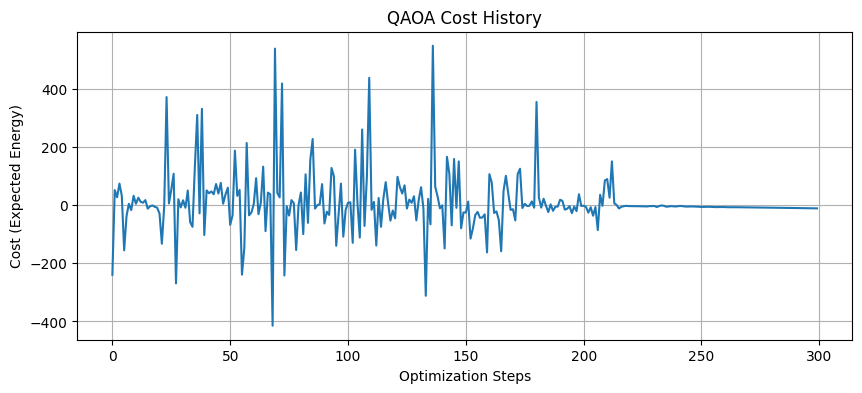

In [20]:
import time
import jax
import optax  # <-- Import the JAX optimizer library
import matplotlib.pyplot as plt # <-- Make sure plt is imported here

print("\n Phase 4: Run the Optimization ")

# 12. Set Optimizer and Training Hyperparameters 
learning_rate = 0.01
optimizer = optax.adam(learning_rate)  # <-- Use optax.adam
steps = 300
print(f"Optimizer: Optax Adam (JAX), Steps: {steps}")

# We'll store our optimized parameters here
# This 'params' is the JAX array you created in Phase 3
optimized_params = params

# Optax requires an optimizer state, initialized from the parameters
opt_state = optimizer.init(optimized_params)

# We'll store the cost history to plot later
cost_history = []

# --- Create the JAX-native update function ---
# Use jax.value_and_grad to get both the cost and the gradient in one go
grad_fn = jax.value_and_grad(cost_circuit)

# We JIT (Just-In-Time compile) this update function.
# This is what gives JAX its speed.
@jax.jit
def update_step(params, opt_state):
    # 1. Get the cost and the gradient
    cost, grads = grad_fn(params)
    
    # 2. Get updates from the optimizer
    #    This is the corrected line:
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    
    # 3. Apply the updates to the parameters
    new_params = optax.apply_updates(params, updates)
    
    return new_params, new_opt_state, cost
# ---

# 13. The Training Loop
print("Starting optimization... (This may take a few minutes)")
start_time = time.time()

for i in range(steps):
    # This is the new core line:
    # It calls our JIT-compiled update_step
    optimized_params, opt_state, cost = update_step(optimized_params, opt_state)
    
    # .item() is needed to get a Python number from a JAX device array
    cost_history.append(cost.item()) 
    
    # Print progress every 20 steps
    if (i + 1) % 20 == 0:
        print(f"Step {i+1:5d} | Cost = {cost:12.6f}")

end_time = time.time()
print("Optimization Complete")
print(f"Total time: {end_time - start_time:.2f} seconds")
print(f"Final cost (minimized energy): {cost_history[-1]:.6f}")

# 14. Plot Cost History 
plt.figure(figsize=(10, 4))
plt.plot(cost_history)
plt.title("QAOA Cost History")
plt.xlabel("Optimization Steps")
plt.ylabel("Cost (Expected Energy)")
plt.grid(True)
plt.savefig("qaoa_cost_history.png")
print("Saved cost history plot to 'qaoa_cost_history.png'")


 Phase 5: Analyze Results 
Running probability circuit...
Best solution (binary): 101010001001110111101010000

 Optimized Schedule 
  ev_charger: Start at time step 8
  washing_machine: Start at time step 84
  dishwasher: Start at time step 92
Total deferrable cost: $172.40
Generating final schedule plot...
Saved final schedule plot to 'qaoa_gpu_final_schedule.png'
 Phase 5 Complete 


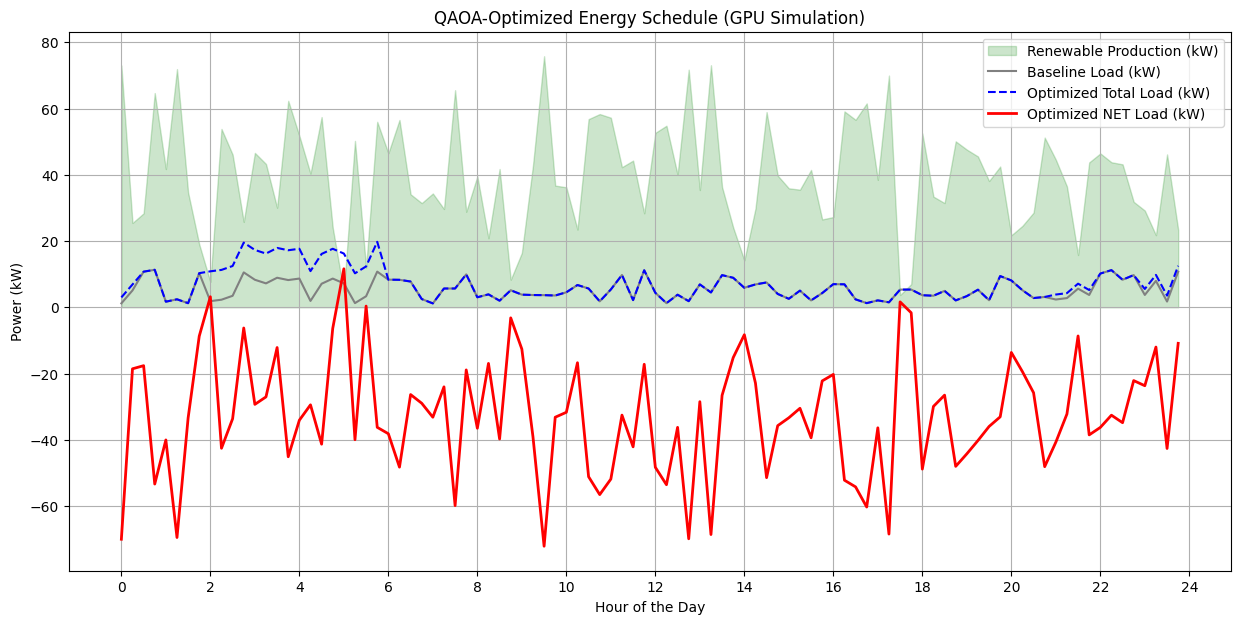

In [22]:
import numpy as np # <-- Make sure we have standard numpy
import matplotlib.pyplot as plt # <-- Make sure plt is imported

print("\n Phase 5: Analyze Results ")

# --- 16. Get Final Probabilities ---
# We create a new QNode to get the final state probabilities
#
# --- CHANGE 1: Add 'interface="jax"' ---
# This must match the interface used for optimization
@qml.qnode(dev, interface="jax")
def prob_circuit(params):
    # 1. Start in the |+> state
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
    
    # 2. Apply p layers (with optimized params)
    for i in range(p):
        gamma = params[i, 0]
        beta = params[i, 1]
        qml.templates.ApproxTimeEvolution(H_Ising, gamma, 1)
        qml.templates.ApproxTimeEvolution(mixer_H, beta, 1)
        
    # 3. Return probabilities of all 2^n_qubits states
    return qml.probs(wires=range(n_qubits))

print("Running probability circuit...")
# 'optimized_params' is a JAX array, so 'probabilities_jax' will be too
probabilities_jax = prob_circuit(optimized_params)

# --- CHANGE 2: Convert JAX array back to a NumPy array ---
# We must copy the data from the GPU back to the CPU (as a NumPy array)
# so that np.argmax and matplotlib can use it.
probabilities = np.asarray(probabilities_jax) 

# --- 17. Decode the Best Solution ---
# The rest of this code now works perfectly, as 'probabilities'
# is a standard NumPy array.
best_solution_int = np.argmax(probabilities)
# Convert the integer to a binary string (e.g., '00...101')
best_solution_str = f"{best_solution_int:0{n_qubits}b}"

print(f"Best solution (binary): {best_solution_str}")
#print(f"Probability: {probabilities[best_solution_int]:.4f}")

# --- 18. Map Solution to Schedule ---
# This is the "decoder"
schedule = {
    'ev_charger': {'start': -1, 'P': 9.0, 'L': 16},
    'washing_machine': {'start': -1, 'P': 1.5, 'L': 4},
    'dishwasher': {'start': -1, 'P': 1.8, 'L': 6}
}
total_cost = 0.0

# Convert from Ising (s_i) back to binary (x_i)
# s = 1 -> x = 0 (off)
# s = -1 -> x = 1 (on)
# But QAOA finds the ground state of H_Ising.
# Let's check the energy of the bitstring
# We assume the bitstring '1' means ON (x=1)
solution_bits = [int(bit) for bit in best_solution_str]

# We must use the original numpy arrays (B_t, C_t, R_t) from Phase 1 here
# Ensure they are available in this cell's scope
for i, bit in enumerate(solution_bits):
    if bit == 1:
        app_name, start_time = reverse_map[i]
        schedule[app_name]['start'] = start_time
        
        # Calculate cost of this run
        app = appliances[app_name]
        P, L = app['P'], app['L']
        cost_of_run = sum(C_t[t % T] for t in range(start_time, start_time + L))
        total_cost += P * cost_of_run

print("\n Optimized Schedule ")
for app_name, details in schedule.items():
    if details['start'] != -1:
        print(f"  {app_name}: Start at time step {details['start']}")
    else:
        print(f"  {app_name}: NOT SCHEDULED (Constraint broken!)")
print(f"Total deferrable cost: ${total_cost:.2f}")


# --- 19. Build Final Load Profile ---
optimized_load = np.zeros(T)
for app_name, details in schedule.items():
    if details['start'] != -1:
        start = details['start']
        L = details['L']
        P = details['P']
        for t_i in range(start, start + L):
            optimized_load[t_i % T] += P

# --- 20. Plot Final Visualization ---
print("Generating final schedule plot...")
time_axis = np.arange(T) * 0.25 # Time in hours

plt.figure(figsize=(15, 7))
plt.fill_between(time_axis, R_t, label="Renewable Production (kW)", color='green', alpha=0.2)
plt.plot(time_axis, B_t, label="Baseline Load (kW)", color='grey')
plt.plot(time_axis, B_t + optimized_load, label="Optimized Total Load (kW)", color='blue', linestyle='--')
plt.plot(time_axis, B_t + optimized_load - R_t, label="Optimized NET Load (kW)", color='red', linewidth=2)

plt.xlabel("Hour of the Day")
plt.ylabel("Power (kW)")
plt.title("QAOA-Optimized Energy Schedule (GPU Simulation)") #<-- updated title
plt.xticks(ticks=range(0, 25, 2))
plt.legend()
plt.grid(True)
plt.savefig("qaoa_gpu_final_schedule.png") #<-- updated filename

print("Saved final schedule plot to 'qaoa_gpu_final_schedule.png'")
print(" Phase 5 Complete ")

# Independent Per-Appliance Optimization

We are running QAOA independently for each appliance (built a local Hamiltonian per appliance, optimized it), then combine the chosen starts into one schedule and plotted the aggregate load.

Consequence: there were no cross‑appliance interaction/penalty terms, so overlaps are allowed (ev_charger and dishwasher both chose start=92). The result is a set of per‑appliance local optima, not a global optimum for the whole grid.


Running QAOA for ev_charger ...
  -> start = 92, cost = $48.00

Running QAOA for washing_machine ...
  -> start = 32, cost = $1.64

Running QAOA for dishwasher ...
  -> start = 92, cost = $3.60

Combined optimized schedule:
  ev_charger: start = 92  cost = $48.00
  washing_machine: start = 32  cost = $1.64
  dishwasher: start = 92  cost = $3.60
Saved qaoa_per_appliance_schedule.png


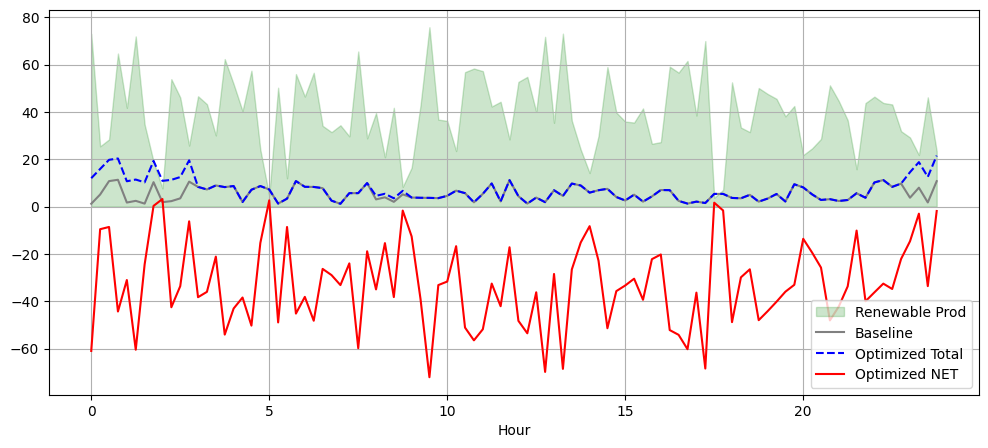

In [5]:
# ...existing code...
import jax
import jax.numpy as jnp
import optax
import numpy as np
import pennylane as qml

def run_qaoa_for_appliance(app_name, app_details, A, B, C, p=2, steps=300, lr=0.01, seed=42):
    # 1) local qubit mapping
    qubit_map = {}
    reverse_map = {}
    for idx, start_time in enumerate(app_details["window"]):
        qubit_map[(app_name, start_time)] = idx
        reverse_map[idx] = (app_name, start_time)
    n_qubits = len(qubit_map)
    if n_qubits == 0:
        return {"start": -1, "cost": 0.0, "optimized_params": None, "cost_history": [], "n_qubits": 0, "offset": 0.0}

    # 2) build local Hamiltonian (h, J, offset) for this appliance only
    h = {}
    J = {}
    offset = 0.0
    P = app_details["P"]; L = app_details["L"]

    # H_cost (linear)
    for (a, start_time), q_idx in qubit_map.items():
        cost_of_run = sum(C_t[t % T] for t in range(start_time, start_time + L))
        C_i_t = P * cost_of_run
        offset += A * C_i_t * 0.5
        h[q_idx] = h.get(q_idx, 0.0) - (A * C_i_t * 0.5)

    # H_constraint for this appliance only
    app_qubits = [qubit_map[(app_name, t)] for t in app_details["window"]]
    offset += C
    for q in app_qubits:
        offset -= 0.5 * C
        h[q] = h.get(q, 0.0) + 0.5 * C
    for i in range(len(app_qubits)):
        for j in range(i + 1, len(app_qubits)):
            q_i = app_qubits[i]; q_j = app_qubits[j]
            offset += 0.5 * C
            h[q_i] = h.get(q_i, 0.0) - 0.5 * C
            h[q_j] = h.get(q_j, 0.0) - 0.5 * C
            key = tuple(sorted((q_i, q_j)))
            J[key] = J.get(key, 0.0) + 0.5 * C

    # H_peak contributions from this appliance only
    for t in range(T):
        net_baseline = B_t[t] - R_t[t]
        offset += B * (net_baseline ** 2)
        L_def_terms = []
        for (a, start_time), q_idx in qubit_map.items():
            is_on = False
            if start_time + L > T:
                if (t >= start_time) or (t < (start_time + L) % T):
                    is_on = True
            else:
                if (t >= start_time) and (t < start_time + L):
                    is_on = True
            if is_on:
                L_def_terms.append((q_idx, P))

        for q_idx, P_i in L_def_terms:
            coeff = B * net_baseline * P_i
            offset += coeff
            h[q_idx] = h.get(q_idx, 0.0) - coeff

        for q_idx, P_i in L_def_terms:
            coeff = 0.5 * B * (P_i ** 2)
            offset += coeff
            h[q_idx] = h.get(q_idx, 0.0) - coeff

        for i in range(len(L_def_terms)):
            for j in range(i + 1, len(L_def_terms)):
                q_i, P_i = L_def_terms[i]
                q_j, P_j = L_def_terms[j]
                coeff = 0.5 * B * P_i * P_j
                offset += coeff
                h[q_i] = h.get(q_i, 0.0) - coeff
                h[q_j] = h.get(q_j, 0.0) - coeff
                key = tuple(sorted((q_i, q_j)))
                J[key] = J.get(key, 0.0) + coeff

    # build PennyLane Hamiltonian (ensure float coefficients)
    h_coeffs = [float(v) for v in h.values()]
    h_obs = [qml.PauliZ(i) for i in h.keys()]
    J_coeffs = [float(v) for v in J.values()]
    J_obs = [qml.PauliZ(i) @ qml.PauliZ(j) for i, j in J.keys()]
    H_Ising_local = qml.Hamiltonian(h_coeffs + J_coeffs, h_obs + J_obs)

    # device
    try:
        dev_local = qml.device("lightning.gpu", wires=n_qubits)
    except qml.DeviceError:
        dev_local = qml.device("default.qubit", wires=n_qubits)

    # mixer
    mixer_H_local = qml.Hamiltonian([1.0] * n_qubits, [qml.PauliX(i) for i in range(n_qubits)])

    # QNodes
    @qml.qnode(dev_local, interface="jax")
    def cost_circuit(params):
        for i in range(n_qubits):
            qml.Hadamard(wires=i)
        for layer in range(p):
            gamma = params[layer, 0]; beta = params[layer, 1]
            qml.templates.ApproxTimeEvolution(H_Ising_local, gamma, 1)
            qml.templates.ApproxTimeEvolution(mixer_H_local, beta, 1)
        return qml.expval(H_Ising_local)

    @qml.qnode(dev_local, interface="jax")
    def prob_circuit(params):
        for i in range(n_qubits):
            qml.Hadamard(wires=i)
        for layer in range(p):
            gamma = params[layer, 0]; beta = params[layer, 1]
            qml.templates.ApproxTimeEvolution(H_Ising_local, gamma, 1)
            qml.templates.ApproxTimeEvolution(mixer_H_local, beta, 1)
        return qml.probs(wires=range(n_qubits))

    # initialize params and optimizer (ensure float dtype)
    np.random.seed(seed)
    numpy_params = (np.random.rand(p, 2) * 0.1).astype(np.float32)
    params = jax.device_put(jnp.array(numpy_params, dtype=jnp.float32))
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)

    # Wrap QNode so JAX sees a real float scalar for grad
    def cost_fn(p):
        return jnp.asarray(cost_circuit(p), dtype=jnp.float32)

    grad_fn = jax.value_and_grad(cost_fn)

    @jax.jit
    def update_step(params, opt_state):
        cost, grads = grad_fn(params)
        updates, new_opt_state = optimizer.update(grads, opt_state, params)
        new_params = optax.apply_updates(params, updates)
        return new_params, new_opt_state, cost

    optimized_params = params
    cost_history = []
    for i in range(steps):
        optimized_params, opt_state, cost = update_step(optimized_params, opt_state)
        cost_history.append(float(cost))

    # get final probabilities and decode best start (local)
    probabilities = np.asarray(prob_circuit(optimized_params))
    best_int = int(np.argmax(probabilities))
    best_bin = f"{best_int:0{n_qubits}b}"  # MSB -> wire0

    chosen_local = None
    for q_idx, bit in enumerate(best_bin):
        if bit == "1":
            chosen_local = q_idx
            break

    if chosen_local is None:
        start_time = -1
        appliance_cost = 0.0
    else:
        _, start_time = reverse_map[chosen_local]
        cost_of_run = sum(C_t[t % T] for t in range(start_time, start_time + L))
        appliance_cost = P * cost_of_run

    return {
        "start": start_time,
        "cost": float(appliance_cost),
        "optimized_params": optimized_params,
        "cost_history": cost_history,
        "n_qubits": n_qubits,
        "offset": float(offset)
    }

# Run QAOA independently for each appliance and collect results
results = {}
for app_name, app_details in appliances.items():
    print(f"\nRunning QAOA for {app_name} ...")
    res = run_qaoa_for_appliance(app_name, app_details, A, B, C, p=p, steps=300, lr=0.01)
    results[app_name] = res
    print(f"  -> start = {res['start']}, cost = ${res['cost']:.2f}")

# Build combined schedule and plot (same plotting as before)
optimized_load = np.zeros(T)
for app_name, res in results.items():
    if res["start"] != -1:
        app = appliances[app_name]
        for t_i in range(res["start"], res["start"] + app["L"]):
            optimized_load[t_i % T] += app["P"]

print("\nCombined optimized schedule:")
for app_name, res in results.items():
    print(f"  {app_name}: start = {res['start']}  cost = ${res['cost']:.2f}")

time_axis = np.arange(T) * 0.25
plt.figure(figsize=(12,5))
plt.fill_between(time_axis, R_t, label="Renewable Prod", color='green', alpha=0.2)
plt.plot(time_axis, B_t, label="Baseline", color='grey')
plt.plot(time_axis, B_t + optimized_load, label="Optimized Total", color='blue', linestyle='--')
plt.plot(time_axis, B_t + optimized_load - R_t, label="Optimized NET", color='red')
plt.xlabel("Hour")
plt.legend(); plt.grid(True)
plt.savefig("qaoa_per_appliance_schedule.png")
print("Saved qaoa_per_appliance_schedule.png")
# ...existing code...